# Pretrain

In general both transfer learning methods follow the same few steps:

- Initialize the pretrained model
- Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
- Define for the optimization algorithm which parameters we want to update during training
- Run the training step

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pickle as pk
from PIL import Image


PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


## Input

### Dataset

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/data1/lipf/cifar-100-python/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 100

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Number of epochs to train for
num_epochs = 10


### Model Training and Validation Code

Training and validation. 

Input : a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate for, and a boolean flag for when the model is an Inception model. 

The is_inception flag is used to accomodate the Inception v3 model. 

The function trains for the specified number of epochs and **after each epoch runs a full validation step**. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model.

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            iters = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                iters += inputs.size(0)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # torch.max(a,1) 返回每一行中最大值的那个元素，且返回其索引，１表示行
                    _, preds = torch.max(outputs, 1)
                    # _, preds = torch.topk(outputs, 5)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # 通过.item() 从0维张量中获得 python number.
                # 如果loss不转为　python number　再累加，内存消耗会一直在增加。因为0维张量会增加梯度的计算历史
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # 转置，然后扩展
                # running_corrects += torch.sum(preds == labels.data.view(1,-1).t().expand_as(preds))
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history




### Set Model Parameters’ .requires_grad attribute

This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. 

However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients.

## INITIALIZE AND RESHAPE THE NETWORKS

When feature extracting, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the .requires_grad attribute to False. This is important because by default, this attribute is set to True. Then, when we initialize the new layer and by default the new parameters have .requires_grad=True so only the new layer’s parameters will be updated. When we are finetuning we can leave all of the .required_grad’s set to the default of True.

In [4]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.avgpool = nn.AvgPool2d(kernel_size=1, stride=1, padding=0)
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 32    

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## LOAD DATA

In [5]:
# Detect if we have a GPU available
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print(device)

cuda:6


In [6]:
def dataLoader(is_train='train', cuda=True, batch_size=512, shuffle=True):
        if is_train == 'train':
            trans = [transforms.RandomHorizontalFlip(),
                     transforms.RandomCrop(32, padding=4),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
            trans = transforms.Compose(trans)
            data_set = datasets.CIFAR100(root='./', train=True, transform=trans)
        else:
            trans = [transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
            trans = transforms.Compose(trans)
            data_set = datasets.CIFAR100('./', train=False, transform=trans)

        return data_set

dataset = {}
for phase in ['train', 'val']:
    dataset[phase] = dataLoader(phase)

dataloaders_dict = {x: torch.utils.data.DataLoader(dataset[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


## CREATE THE OPTIMIZER

In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999))

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

## RUN TRAINING AND VALIDATION STEP

In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=50)

Epoch 0/49
----------
train Loss: 2.7881 Acc: 0.2998
val Loss: 2.2118 Acc: 0.4140

Epoch 1/49
----------
train Loss: 1.9632 Acc: 0.4684
val Loss: 1.9228 Acc: 0.4785

Epoch 2/49
----------
train Loss: 1.6988 Acc: 0.5269
val Loss: 1.8272 Acc: 0.5140

Epoch 3/49
----------
train Loss: 1.5244 Acc: 0.5695
val Loss: 1.7238 Acc: 0.5349

Epoch 4/49
----------
train Loss: 1.3910 Acc: 0.6003
val Loss: 1.7071 Acc: 0.5406

Epoch 5/49
----------
train Loss: 1.2800 Acc: 0.6299
val Loss: 1.6287 Acc: 0.5618

Epoch 6/49
----------
train Loss: 1.3071 Acc: 0.6278
val Loss: 16.3962 Acc: 0.4737

Epoch 7/49
----------
train Loss: 1.5268 Acc: 0.5715
val Loss: 1.6000 Acc: 0.5627

Epoch 8/49
----------
train Loss: 1.1628 Acc: 0.6577
val Loss: 1.6039 Acc: 0.5735

Epoch 9/49
----------
train Loss: 1.0397 Acc: 0.6887
val Loss: 1.8014 Acc: 0.5290

Epoch 10/49
----------
train Loss: 1.0577 Acc: 0.6858
val Loss: 2.3358 Acc: 0.5018

Epoch 11/49
----------
train Loss: 0.9745 Acc: 0.7029
val Loss: 1.7835 Acc: 0.5774

E

## Save model

In [9]:
# save parameters
save_path = './acc_6067.pth'
torch.save(model_ft.cpu().state_dict(), save_path)

## Plot accuracy

In [10]:
def plotacc(hist, num_epochs):
    ohist = []

    ohist = [h.cpu().numpy() for h in hist]

    plt.title("Validation Accuracy")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 5.0))
    plt.legend()
    plt.show()

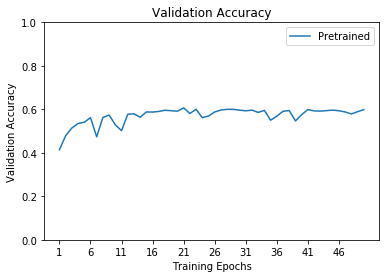

In [11]:
plotacc(hist, 50)